# Банки — Анализ оттока клиентов

## Задача**:**

Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.

## Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

# Шаг 1. Обзор данных

### 1.1 Импорт библиотек

In [1]:
#импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### 1.2 Открыть файл

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')
data.sample(5)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
8856,15802469,774,Ярославль,Ж,26,5,NaN,2,1,1,64716.08,0
7488,15730501,538,Ростов Великий,Ж,42,4,80380.24,1,1,0,119216.46,0
6930,15723421,751,Ярославль,М,30,3,165257.20,1,0,0,134822.05,0
8275,15780225,610,Рыбинск,Ж,46,5,116886.59,1,0,0,107973.44,0
4992,15825755,794,Ярославль,Ж,62,9,123681.32,3,1,0,173586.63,1


# Шаг 2. Предобработка данных

### 2.1 Приведем данные к нужным типам

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Типы данных корректны

### 2.2 Приведем наименование столбцов к нижнему регистру

In [4]:
data.columns = data.columns.str.lower()

In [5]:
data

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1


### 2.3 Проверим данные на пропуски

In [6]:
data.isna().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Пропуски только в столбце "balance ", не везде указана заработная плата, что достаточно странно, но оставим как есть.

In [8]:
#Найдем процент пропущенных значений в 'balance'
total_lines_balance = len(data['balance'].axes[0])
total_balance = data['balance'].count()
conversion_balance = ((total_lines_balance - total_balance) / total_lines_balance)*100
conversion_balance

36.17

In [7]:
#Проверим в каких городах отсутствуют данные по зарплате
data[(data['balance'].isnull() == True)]['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

Данные отсутствуют в городе Ярославль и Рыбинск, больше всего в Ярославле - 2418 из 3617 значений.

In [8]:
#Проверим у каких клиентов отсутствуют данные по зарплате, которые имеют кредитную карту а кто нет
data[(data['balance'].isnull() == True)]['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

У 70 %  клиентов с отсутствием счета в банке есть кредитная карта. 

In [9]:
data[(data['balance'].isnull() == True)]['loyalty'].value_counts()

1    1873
0    1744
Name: loyalty, dtype: int64

По активнсти  клиенты у которых отсутствуют данные по балансу на счете почти равны.

In [10]:
data[(data['balance'].isnull() == True)]['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Пропуски данных по балансу на счете есть только в Ярославле и Рыбинске. По активнсти клиенты у которых отсутствуют данные по балансу на счете почти равны. У 70 % клиентов с отсутствием баланса на счету есть кредитная карта. Так же всего 500 клиентов ушли в отток, значит, что клиенты без данных о балансе на счете в большинстве остаются в банке. Я могу сделать вывод о том, что Люди которые проживают в Ярославле и Рыбинске имеют счет с дебетовыми картами в другом банке или причина появления данных пропусков может иметь технический характер, что-то произошло при выгрузке данных  

### 2.4 Проверим данные на отсутствие дубликатов

In [11]:
data.duplicated().sum()

0

Дубликаты отсутствуют

In [12]:
data['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

Половина клиентов из Ярославля. Это можно объяснить к примеру, что в Ярославле, это рабочий банк, т.е людям туда переводят зп, А в Ростове и Рыбинске клиенты пользуются ими для держания своих накоплений и открытия кредитных карт

### 2.5 Категоризация данных

In [13]:
data_new = data.copy()

Посмотрев данные в интернете по минимальной и средней зп в данных городах можно распределить их по уровню дохода. Минимальная зп 15279 руб., средняя зп 45000 руб.

In [14]:
#напишем функцию, которая распределяет уровень дохода по категориям
def category(data_new):
    
    if data_new['estimated_salary'] <= 15279:
        return 'низкий достаток'
    
    elif data_new['estimated_salary'] <= 45000:
        return 'средний достаток'
    
    else:
        return 'высокий достаток'

#добавим новый столбец в таблицу
data_new['category'] = data_new.apply(category, axis=1)

#выведем первые 3 строки таблицы, чтобы проверить новый столбец
data_new.head(3)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий достаток
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий достаток
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий достаток


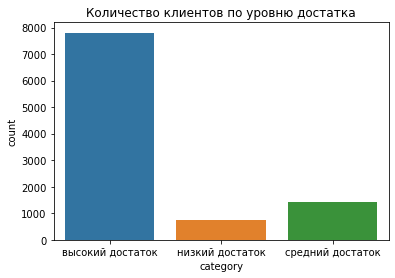

In [15]:
sns.countplot(x = 'category', data = data_new)
plt.title('Количество клиентов по уровню достатка');

В данной выборке больше 70 % клиентов имеют высокий достаток.

С 11 ноября 2020 года Государственная дума одобрила проект о повышении возраста молодёжи до 35 лет (с 14 до 35 лет). И с 2019 по 2028 год. По итогу пенсионный возраст в России будет повышен на 5 лет: до 60 лет — для женщин, до 65 лет — для мужчин. Предлагаю в среднем взять еще по предыдущим данным, когда на пенсию уходили в 55 женщины и в 60 мужщины, получаем в среднем 58 лет. 

In [16]:
#напишем функцию, которая распределяет возраст по категориям
def age_category(data_new):
    
    if data_new['age'] <= 35:
        return 'молодой'
    
    elif data_new['age'] <= 58:
        return 'среднего возраста'
    
    else:
        return 'пенсионного возраста'

#добавим новый столбец в таблицу
data_new['age_category'] = data_new.apply(age_category, axis=1)

data_new.head(3)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,category,age_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий достаток,среднего возраста
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий достаток,среднего возраста
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий достаток,среднего возраста


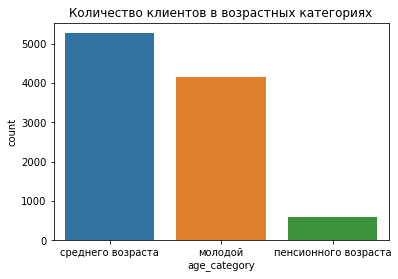

In [17]:
sns.countplot(x = 'age_category', data = data_new)
plt.title('Количество клиентов в возрастных категориях');

Более 50 % клиентов среднего возраста

Категоризация по числу объектов в собстенности

In [18]:
data_new['objects'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

In [19]:
#напишем функцию по категоризации по числу объектов в собстенности
def objects_category(data_new):
    
    if data_new['objects'] == 0:
        return 'нет объектов'
    
    elif data_new['objects'] < 3:
        return '1-2 объекта'
    
    elif data_new['objects'] <= 5:
        return '3-5 объектов'
    
    else:
        return 'боле 5 объектов'

#добавим новый столбец в таблицу
data_new['objects_category'] = data_new.apply(objects_category, axis=1)

data_new.head(3)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,category,age_category,objects_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий достаток,среднего возраста,1-2 объекта
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий достаток,среднего возраста,1-2 объекта
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий достаток,среднего возраста,боле 5 объектов


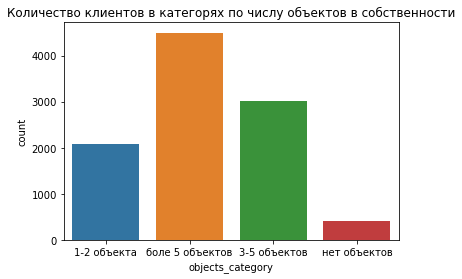

In [20]:
sns.countplot(x = 'objects_category', data = data_new)
plt.title('Количество клиентов в категорях по числу объектов в собственности');

Большее количество клиентов в данной выборки имеют более 5 объектов.

Распределение по уровню score по категориям

По данным в интернете показатель от 701 до 1000 баллов позволяет рассчитывать на выгодные условия по кредиту, 501–700 — на стандартные условия, 0–500 — на невыгодные условия займов и повышенный риск отказа

In [21]:
#напишем функцию, которая распределяет уровень score по категориям
def score_category(data_new):
    
    if data_new['score'] < 500:
        return 'низкий уровень'
    
    elif data_new['score'] <= 700:
        return 'средний уровень'
    
    else:
        return 'высокий уровень'

#добавим новый столбец в таблицу
data_new['score_category'] = data_new.apply(score_category, axis=1)

data_new.head(3)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,category,age_category,objects_category,score_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий достаток,среднего возраста,1-2 объекта,средний уровень
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий достаток,среднего возраста,1-2 объекта,средний уровень
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий достаток,среднего возраста,боле 5 объектов,средний уровень


Text(0.5, 1.0, 'Кол-во клиентов в категорях по банковскому скорингу')

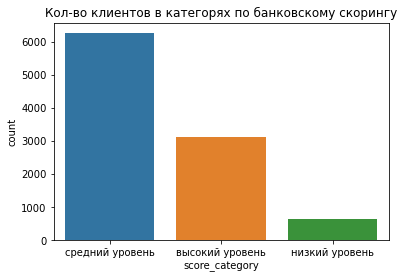

In [22]:
sns.countplot(x = 'score_category', data = data_new)
plt.title('Кол-во клиентов в категорях по банковскому скорингу')

У большинства клиентов в категорях по банковскому скорингу имеют средний уровень

Распределение баланса на счету по категориям

In [23]:
data_new['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

Посмотрим сколко человек имеют на балансе меньше 5000р, от 5000 до 30000р, от 30000 до 50000р, от 50000 до 100000р, и те кто более 100000р. 

In [24]:
#напишем функцию, которая распределяет баланс на счету по категориям
def balance_category(data_new):
    
    if data_new['balance'] <= 5000:
        return 'менее 5000р'
    
    elif data_new['balance'] <= 30000:
        return '5 000 - 30 000р'
    
    elif data_new['balance'] <= 50000:
        return '30 000 - 50 000р'
    
    elif data_new['balance'] <= 50000:
        return '50 000 - 100 000р'
    
    else:
        return 'более 100 000р'

#добавим новый столбец в таблицу
data_new['balance_category'] = data_new.apply(balance_category, axis=1)

data_new.head(3)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,category,age_category,objects_category,score_category,balance_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий достаток,среднего возраста,1-2 объекта,средний уровень,более 100 000р
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий достаток,среднего возраста,1-2 объекта,средний уровень,более 100 000р
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий достаток,среднего возраста,боле 5 объектов,средний уровень,более 100 000р


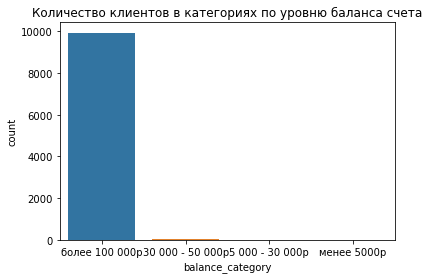

In [25]:
sns.countplot(x = 'balance_category', data = data_new)
plt.title('Количество клиентов в категориях по уровню баланса счета');

In [26]:
data_new['balance_category'].value_counts()

более 100 000р      9925
30 000 - 50 000р      63
5 000 - 30 000р       11
менее 5000р            1
Name: balance_category, dtype: int64

In [27]:
data_new['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

У 99 % клиентов на счете более 100000 рублей.

In [28]:
data.describe().round()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.0,10000.0,10000.0,10000.0,6383.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,15733677.0,651.0,39.0,5.0,119827.0,2.0,1.0,1.0,100090.0,0.0
std,71936.0,97.0,10.0,3.0,30095.0,1.0,0.0,0.0,57510.0,0.0
min,15608437.0,350.0,18.0,0.0,3769.0,1.0,0.0,0.0,12.0,0.0
25%,15671264.0,584.0,32.0,3.0,100182.0,1.0,0.0,0.0,51002.0,0.0
50%,15733474.0,652.0,37.0,5.0,119840.0,1.0,1.0,1.0,100194.0,0.0
75%,15795970.0,718.0,44.0,7.0,139512.0,2.0,1.0,1.0,149388.0,0.0
max,15858426.0,850.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0


## Вывод

Дубликаты отсутствуют

Провели классификацию клиентов по уровню дохода, возрасту, числу объектов в собственности и кредитному скорингу. В данной выборке преобладают клиенты среднего возраста, с высоким достатком, средним уровнем кредитного скоринга, у которых во владении более 5 объектов и более 100 000р на балансе.

 В данной выборке у нас все клиенты уникальные и их 10 000 чел.

• В среднем здесь стабильные клиенты, имеющие результат кредитного скоринга равный в среднем 650 баллов, что достаточно для получения кредита.

• Клиентам от 18 до 92 лет, что означает, что все совершеннолетние и в среднем клиенту 39 лет.

• Мужчин и женщин примерно поровну.

• В среднем у клиентов в собственности 5 объектов.

• На счету у них в среднем около 120 000р.

• В среднем клиенты пользуются 1-2 продуктами. Но максимум 4.

• Клиенты в среднем имеют кредитную карту, чем нет, а вот по активности картина уже так себе, активны всего около половины клиентов.

• Зарплаты  в основном выше средней зп по этим городам - около 100 000р.

• Более чем у половны клиентов есть действующий счет в банке.


# Шаг 3. Исследовательский анализ данных

### 3.1  распределения для тех кто ушел и кто остался

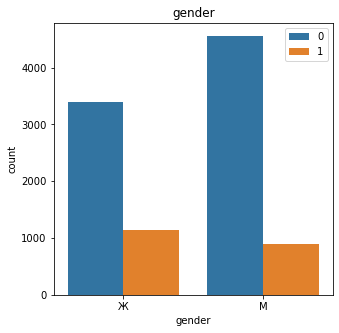

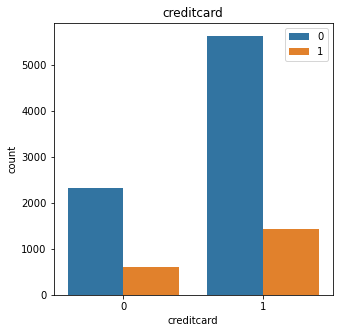

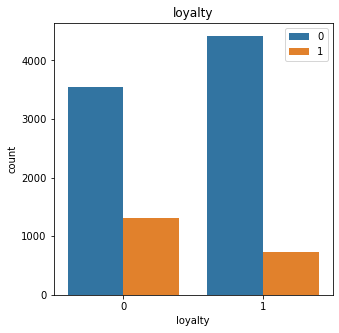

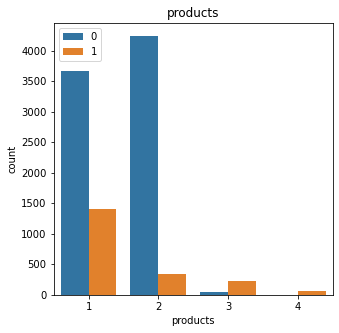

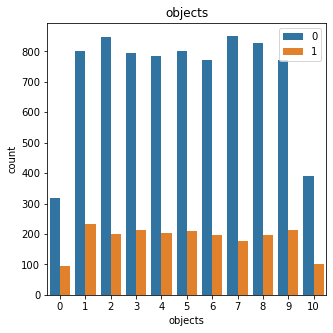

In [29]:
#countplot-графики для бинарных признаков.
for column in ['gender', 'creditcard', 'loyalty', 'products', 'objects']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='churn', data=data)
    plt.title(column)
    plt.legend()
    plt.show()

В отток  уходят:

* чуть больше женщин,
* у кого есть кредитная карта,
* клиенты, которые являются менее активными,
* У кого есть 1 или 2 продукта, и те у кого 4 продукта, 100% ушли в отток.

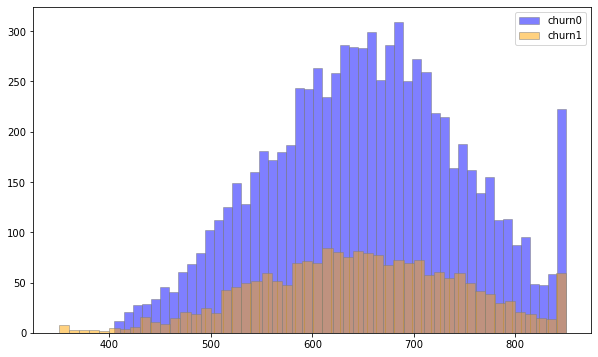

In [30]:
data1 = data.query('churn == 1')['score']
data0 = data.query('churn == 0')['score']

plt.figure(figsize=(10,6))
plt.hist(data0, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'churn0', density = False)
plt.hist(data1, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'churn1', density = False)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Диаграмма размаха по score и churn')

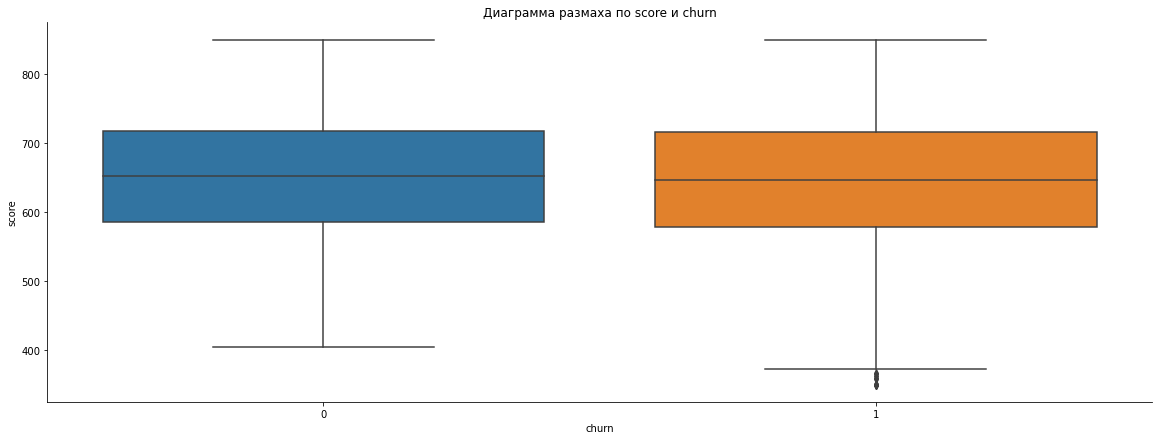

In [31]:
#Построим диаграмму размаха по score.
sns.catplot(x='churn', y="score", kind="box", data=data, height=6, aspect=2.7)
plt.title('Диаграмма размаха по score и churn')
#sns.set(rc={'figure.figsize':(14,14)})
#_ = plt.ylim(0, 3)

Выбросы набдюдаются у клиентов которые ушли в отток, у них score наблюдается аж менее 400 баллов, те это те клиенты которым менее вероятно дали бы займ в банке

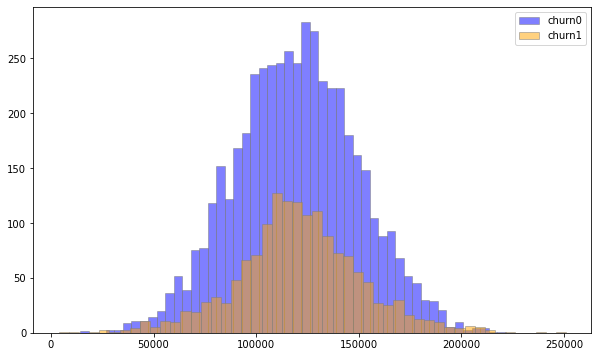

In [32]:
data1 = data.query('churn == 1')['balance']
data0 = data.query('churn == 0')['balance']

plt.figure(figsize=(10,6))
plt.hist(data0, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'churn0', density = False)
plt.hist(data1, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'churn1', density = False)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Диаграмма размаха по balance и churn')

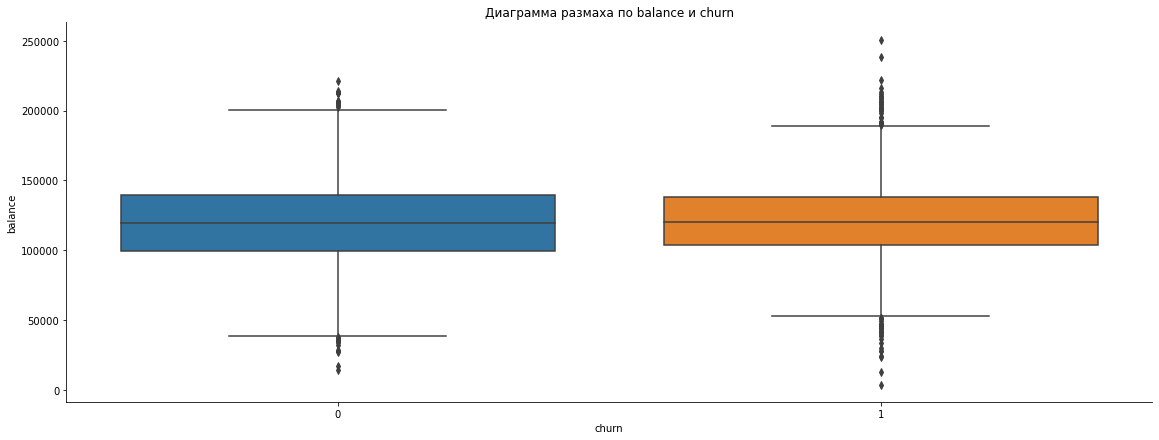

In [33]:
#Построим диаграмму размаха по balance.
sns.catplot(x='churn', y="balance", kind="box", data=data, height=6, aspect=2.7)
plt.title('Диаграмма размаха по balance и churn')
#sns.set(rc={'figure.figsize':(14,14)})
#_ = plt.ylim(0, 3)

По балансу наблюдаем выбросы как в оттоке так и у клиентов которые остались, у клиентов которые остались выбросы видим менее 40000 рублей и более 200000рублей. А у клиентов которые ушли в отток видим выбросы менее 50000рублей и более 185000 рублей

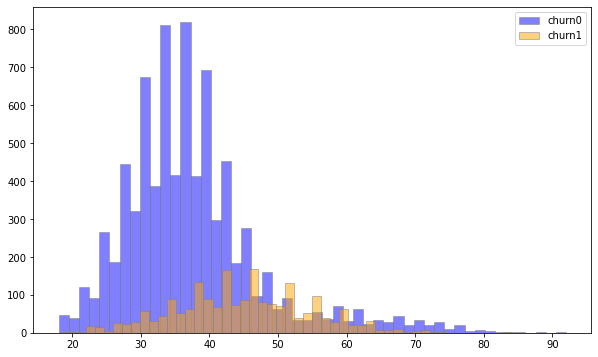

In [34]:
data1 = data.query('churn == 1')['age']
data0 = data.query('churn == 0')['age']

plt.figure(figsize=(10,6))
plt.hist(data0, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'churn0', density = False)
plt.hist(data1, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'churn1', density = False)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Диаграмма размаха по age и churn')

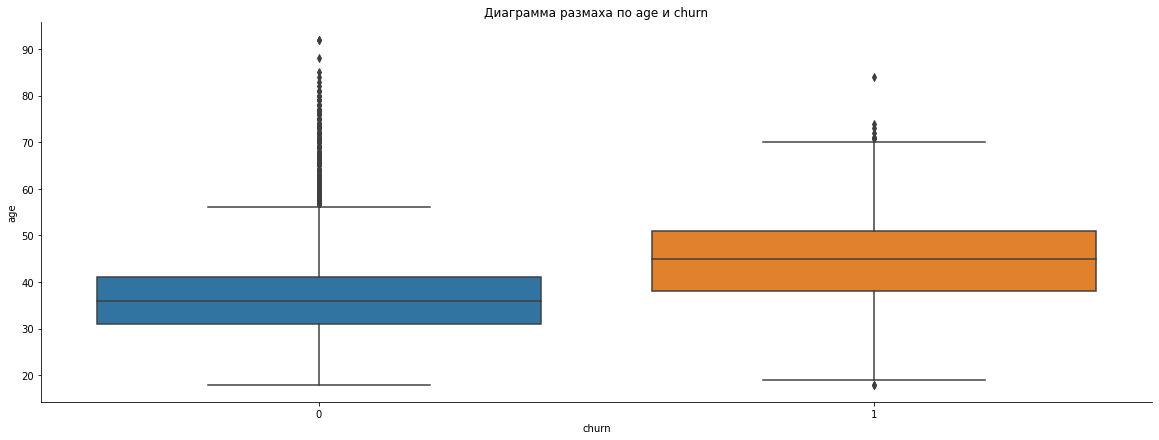

In [35]:
#Построим диаграмму размаха по age.
sns.catplot(x='churn', y="age", kind="box", data=data, height=6, aspect=2.7)
plt.title('Диаграмма размаха по age и churn')
#sns.set(rc={'figure.figsize':(14,14)})
#_ = plt.ylim(0, 3)

По возросту наблюдаем выбросы у клиентов которые остались в банке, это клиенты в старше 58 лет и до 92 года. У клиентов которые ушли в отток видим выбросы менее 20 лет и клиенты, которые старше 70 лет.

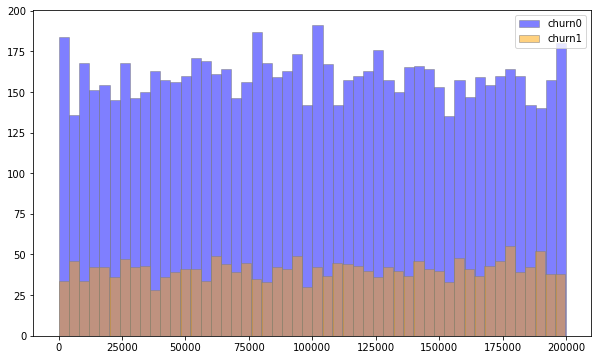

In [36]:
data1 = data.query('churn == 1')['estimated_salary']
data0 = data.query('churn == 0')['estimated_salary']

plt.figure(figsize=(10,6))
plt.hist(data0, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'churn0', density = False)
plt.hist(data1, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'churn1', density = False)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Диаграмма размаха по estimated_salary и churn')

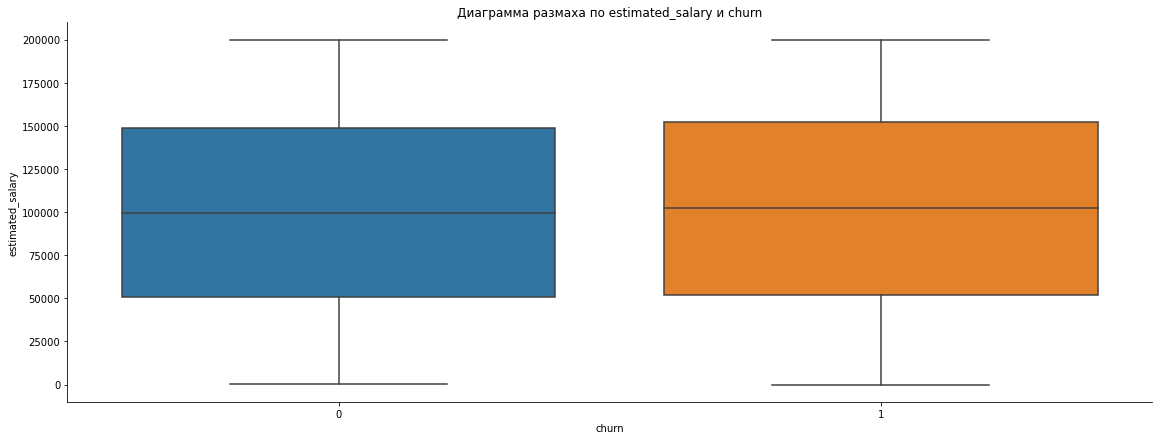

In [37]:
#Построим диаграмму размаха по заработной плате.
sns.catplot(x='churn', y="estimated_salary", kind="box", data=data, height=6, aspect=2.7)
plt.title('Диаграмма размаха по estimated_salary и churn')
#sns.set(rc={'figure.figsize':(14,14)})
#_ = plt.ylim(0, 3)

По заработной плате выбросов не наблюдаем

В отток  уходит чуть больше женщин, чем мужчин, у кого есть кредитная карта, действующий счет в банке и в большинстве клиенты, которые являются неактивными.По численности в отток уходит больше клиентов имеющих в собственности от 1 до 9 объектов. Так же в отток 100% уходят те у кого уровень score менее 400 баллов. 

### 3.2 Посмотрим на средние показатели по клиентам которые ушли и которые остались

In [38]:
#Посмотрим на общий процент оттока
data['churn'].value_counts(normalize = True).round(2).reset_index()

,index,churn
0,0,0.8
1,1,0.2


Из общего числа клиентов банка присутствуют только 20%  которые ушли (отток).

In [39]:
data.groupby('churn').agg('mean').round()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,15733904.0,652.0,37.0,5.0,119536.0,2.0,1.0,1.0,99738.0
1,15732788.0,645.0,45.0,5.0,120747.0,1.0,1.0,0.0,101466.0


Если смотреть на средние показатели клиентов которые ушли и которые остались, то слишком явного различия не видно. Но остается клиент, который имеет меньшую активность и по возрасту в среднем 45 лет, а зарплата, баланс на счете и объекты в собственности в среднем одинаковые.

### 3.3 Посмотрим матрицу корреляции

Переведем названия городов в числовые значения, чтобы можно было обучить модель.

In [9]:
data = pd.get_dummies(data, columns=['city'])

Заменим пол на единицы и нули, чтобы посмотреть статистику по полу.

In [10]:
data['gender'] = data['gender'].replace({'Ж':0, 'М': 1})

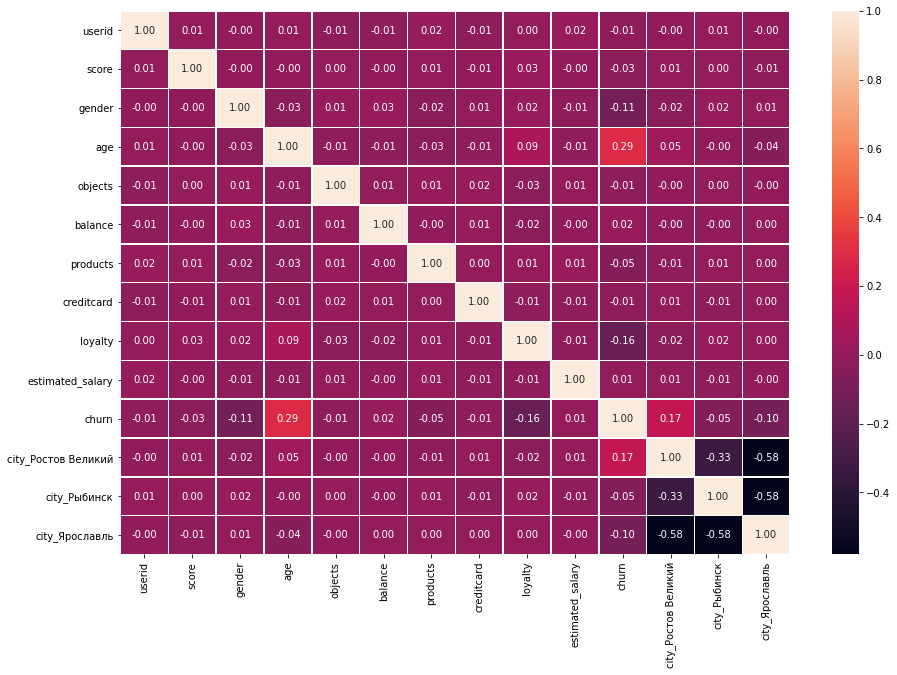

In [11]:
corr = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot = True, fmt = '0.2f', linewidths=.5)
plt.show()

Шкала Чеддока

0,1 - 0,3	Слабая

0,3 - 0,5	Умеренная

0,5 - 0,7	Заметная

0,7 - 0,9	Высокая

0,9 - 0,99	Весьма высокая

## Вывод
По матрице корреляций можно сказать, что влияние на отток имеют такие признаки как возраст (слабая корреляция), активность (очень слабая корреляция), пол (очень слабая корреляция) и продукты(так же очень слабая корреляция). Если смотреть по городам, то больше всего на отток влияет Ростов.



# Шаг 4. Сделайте кластеризацию клиентов

### 4.1 Построение иерархической кластеризации

In [42]:
data['balance'].replace(np.nan, 0, inplace=True)

In [44]:
data_cl = data.drop(['churn'], axis=1)
data_columns_list = data_cl.columns
data_cl.head()

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,0,42,2,0.00,1,1,1,101348.88,0,0,1
1,15690047,608,0,41,1,83807.86,1,0,1,112542.58,0,1,0
2,15662040,502,0,42,8,159660.80,3,1,0,113931.57,0,0,1
3,15744090,699,0,39,1,0.00,2,0,0,93826.63,0,0,1
4,15780624,850,0,43,2,125510.82,1,1,1,79084.10,0,1,0


In [45]:
data_cl = StandardScaler().fit_transform(data_cl)
data_cl = pd.DataFrame(data_cl, columns = data_columns_list).astype('float64')

In [46]:
data_cl

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,-0.783213,-0.326221,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,-0.578736,-0.573809,0.997204
1,-0.606534,-0.440036,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-0.578736,1.742740,-1.002804
2,-0.995885,-1.536794,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,-0.578736,-0.573809,0.997204
3,0.144767,0.501521,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,-0.578736,-0.573809,0.997204
4,0.652659,2.063884,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-0.578736,1.742740,-1.002804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.177652,1.246488,0.912419,0.007457,-0.004426,-1.225848,0.807737,0.646092,-1.030670,-0.066419,-0.578736,-0.573809,0.997204
9996,-1.682806,-1.391939,0.912419,-0.373958,1.724464,-0.306379,-0.911583,0.646092,0.970243,0.027988,-0.578736,-0.573809,0.997204
9997,-1.479282,0.604988,-1.095988,-0.278604,0.687130,-1.225848,-0.911583,-1.547768,0.970243,-1.008643,-0.578736,-0.573809,0.997204
9998,-0.119356,1.256835,0.912419,0.293517,-0.695982,-0.022608,0.807737,0.646092,-1.030670,-0.125231,1.727904,-0.573809,-1.002804


In [47]:
linked = linkage(data_cl, method = 'ward')

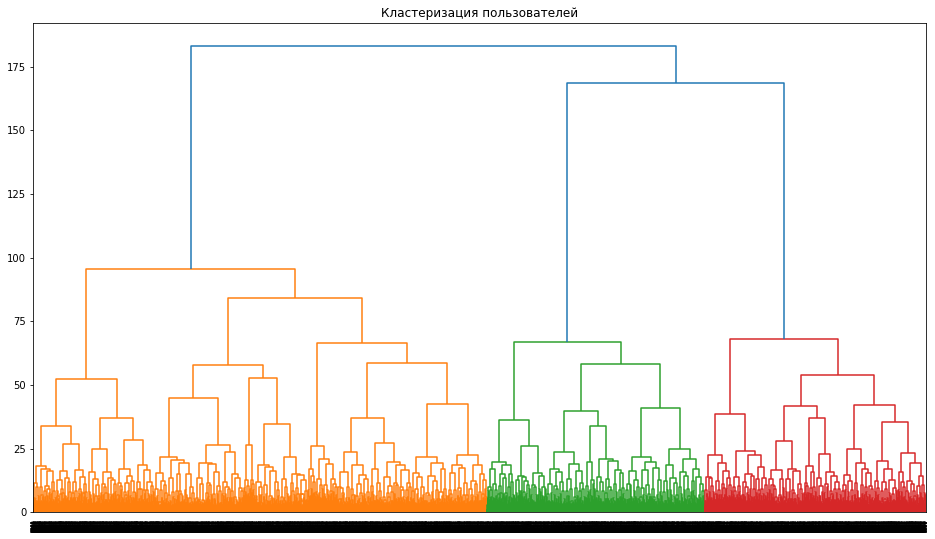

In [48]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Можно выделить 3 явных кластера клиентов.

### 4.2 Обучение модели кластеризации на основании алгоритма k_means

In [49]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters = 3, random_state = 42)

### 4.3 Прогнозируем кластеры для наблюдений 

In [50]:
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(data_cl)
# сохраняем метки кластера в поле нашего датасета
data['cluster'] = labels

In [51]:
data.cluster.value_counts()

2    5014
0    2509
1    2477
Name: cluster, dtype: int64

### 4.4 Посмотрим на средние значения признаков для кластеров

In [52]:
data.groupby('cluster').mean()

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль
cluster,,,,,,,,,,,,,,
0,1.573329e+07,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,1.0,0.0,0.0
1,1.573465e+07,651.333872,0.560355,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734,0.0,1.0,0.0
2,1.573339e+07,649.668329,0.549063,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548,0.0,0.0,1.0


• Самым многочисленным кластером является 2-oй, он же на 3 месте по оттоку - 16,15%.
• Наибольший отток в кластере 0 - 32% и он на 2 месте по численности.

### 4.5 Построим распределения признаков для кластеров

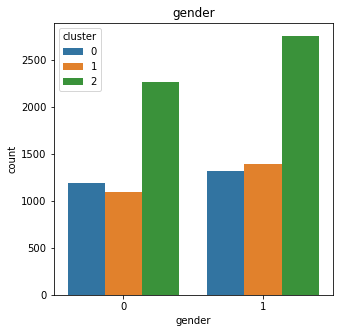

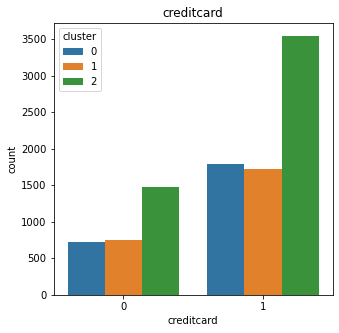

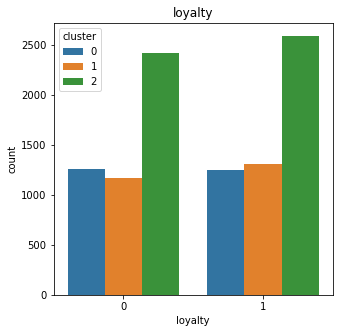

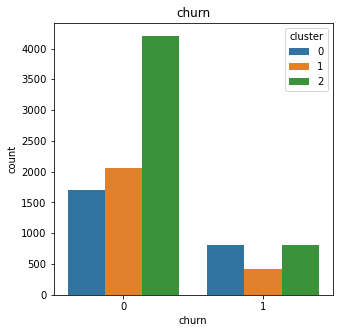

In [53]:
for column in ['gender', 'creditcard', 'loyalty', 'churn']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='cluster', data=data)
    plt.title(column)
    plt.show()

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

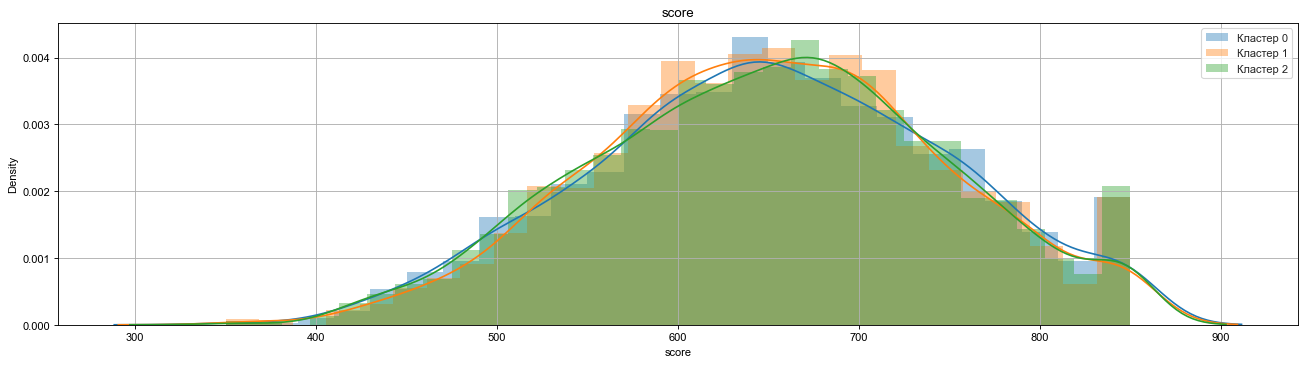

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py

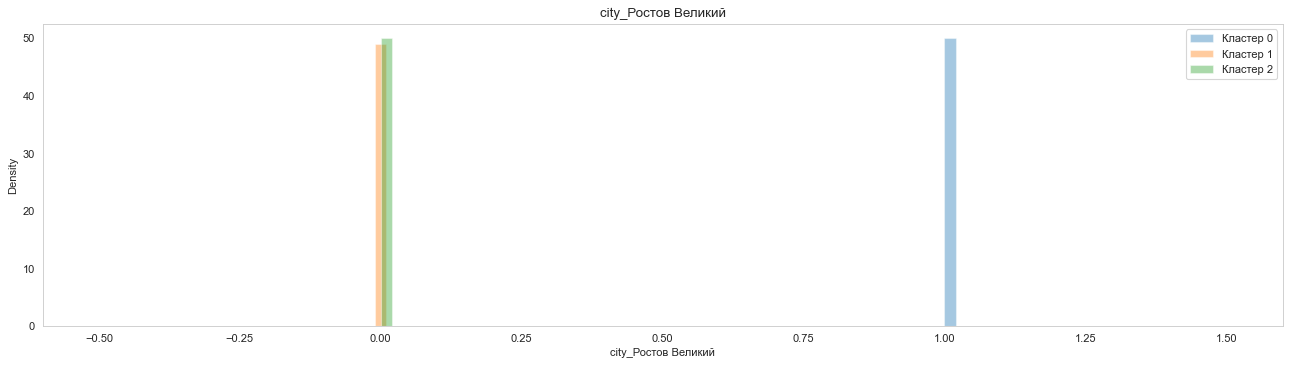

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py

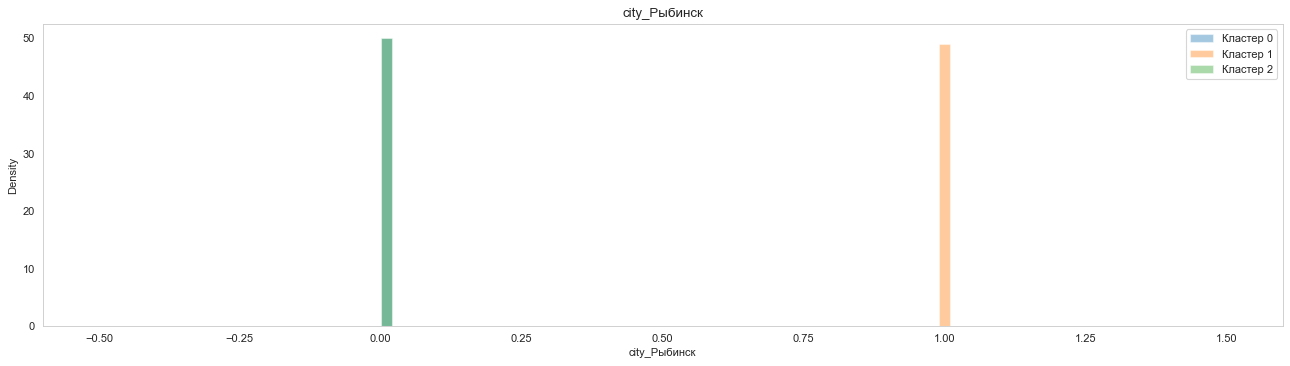

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py

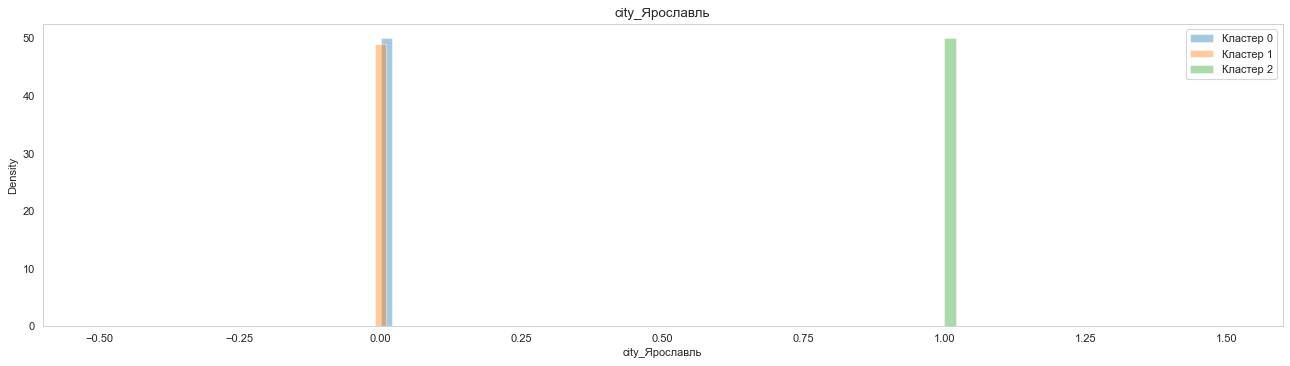

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

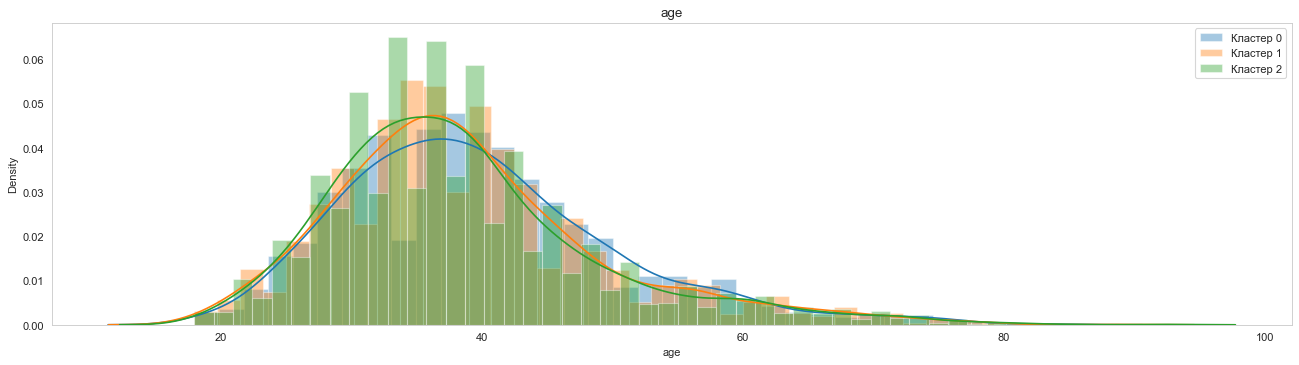

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

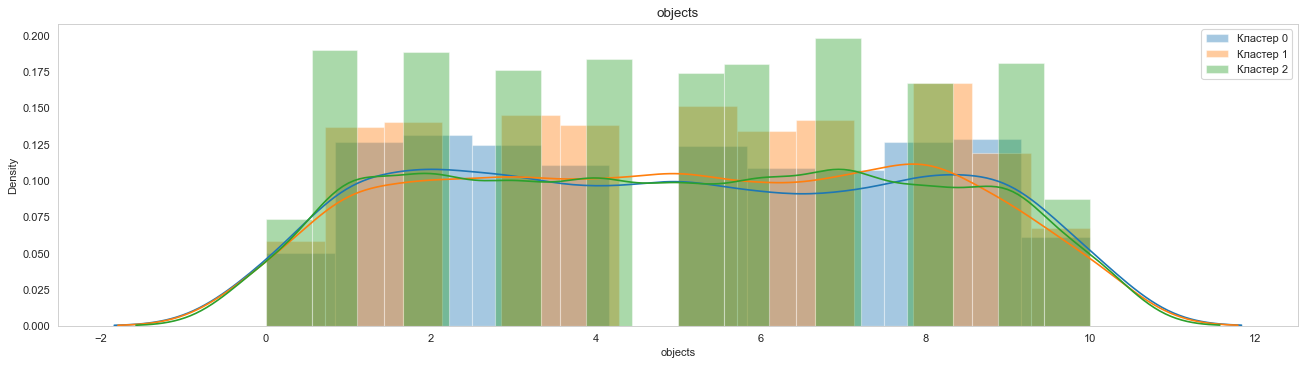

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

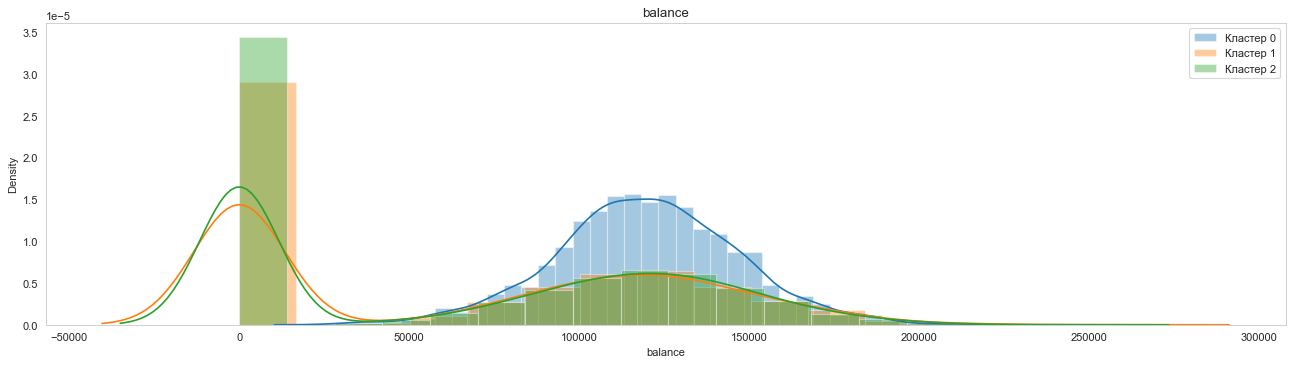

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

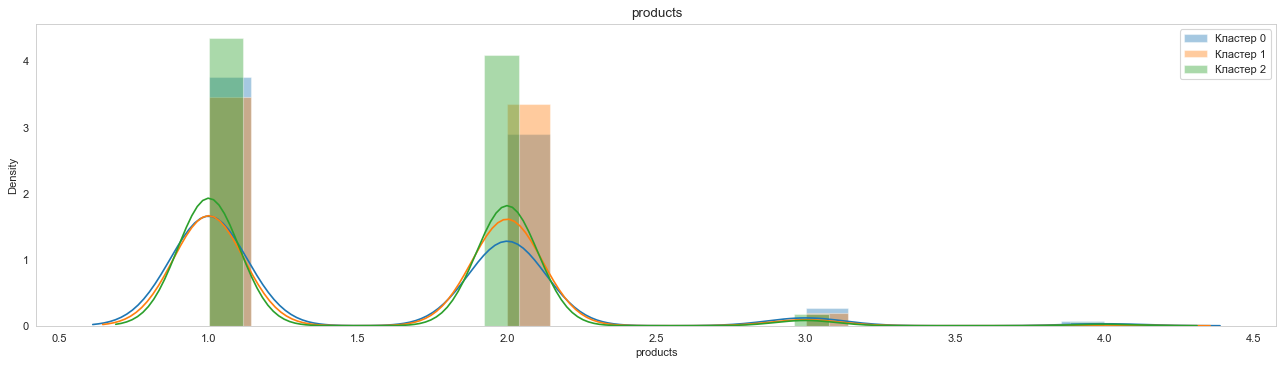

C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\chebu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

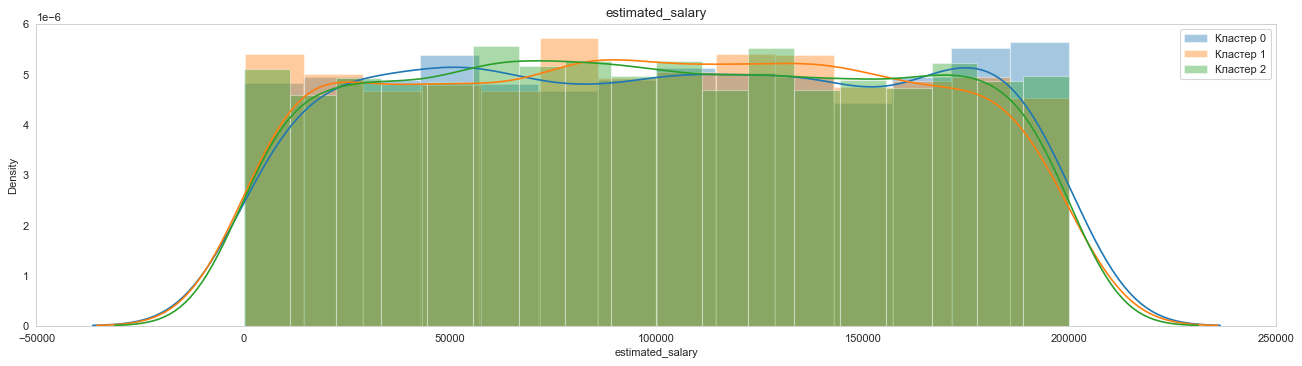

In [54]:
for column in ['score', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль', 'age', 'objects', 'balance', 'products', 'estimated_salary']:
    plt.figure(figsize=(20,5), dpi= 80)
    plt.title(column)   
    sns.distplot(data.query('cluster==0')[column], label = 'Кластер 0')
    sns.distplot(data.query('cluster==1')[column], label = 'Кластер 1')
    sns.distplot(data.query('cluster==2')[column], label = 'Кластер 2')
    plt.legend(loc = 2)
    sns.set_style('whitegrid')
    plt.grid()
    plt.legend()
    plt.show()

## Вывод

Мы разбили всех наших клиентов на 3 группы

Как выяснилось, клиентов мужщин больше, чем женщин; средний возраст 38-40 лет; баллов скорринга в среднем у всех одинаково; в среднем везде по 5 объектов, баланс в 0 кластере самый высокий; в среднем продуктов 2, кредитных карт больше есть, чем их нет;по лояльности клиенты одинаковы, заработная плата в среднем у всех одинакова.

Распишем каждый кластер в отдельности:

Кластер 0

* Отток - 32,44% - самый высокий
* Женщин в этом кластере больше всего, но мужщин по количеству все равно больше
* возраст 40 лет
* Продуктов в среднем 5
* Самый высокий баланс на карточке (120 т.р)
* Самый большой процент кредитных карт в наличии
* менее лояльные клиенты(на 1 месте)
* больше всего зп на карте (на 1 месте).
* Клиенты из Ростова

Кластер 1

* Отток - 16,67% 
* Женщин в этом кластере меньше всего, но мужщин по количеству все равно больше
* возраст ближе к 39 
* Продуктов в среднем 5
* Самый низкий баланс на карте(61,8 т.р)
* Самый маленький  процент кредитных карт в наличии
* по лояльности клиенты(на 1 месте)
* меньше всего зп на карте (на 3 месте).
* Клиенты из Рыбинска

Кластер 2

* Женщин в этом кластере так же меньше чем мужщин по количеству 
* возраст ближе к 39 
* Продуктов в среднем 5
* Баланс на карте(62 т.р)
* на 2 месте по  проценту кредитных карт в наличии
* по лояльности клиенты(на 2 месте)
* Зп на карте почто так же как в 2 кластере.
* Клиенты из Ярославля

В отток чаще всего уходят клиенты из кластера 0

# Шаг 5. Сформулируйте и проверьте статистические гипотезы

У нас есть 2 группы: churn1 - клиенты которые ушли в отток и группа churn0 - клиенты которые остались.

### 5.1 Посчитаем статистическую значимость различий в среднем доходе между теми, кто ушёл и теми, кто остался

Гипотезы

H0: Между группами churn1 и churn0 нет различий в среднем доходе

H1: Между группами churn1 и churn0 есть различие в среднем доходе

In [55]:
#Посмотрим на разницу в среднем доходе между группами
data.groupby('churn')['estimated_salary'].mean()

churn
0     99738.391772
1    101465.677531
Name: estimated_salary, dtype: float64

In [56]:
alpha = 0.05
salary_1 = data.query('churn == 1')['estimated_salary']
salary_2 = data.query('churn == 0')['estimated_salary']
results = st.ttest_ind(salary_1, salary_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу


### 5.2  Посчитаем статистическую значимость различий в возрасте между теми, кто ушёл и теми, кто остался

Гипотезы

H0: Между группами churn и no_churn нет различий в среднем возрасте
    
H1: Между группами churn и no_churn есть различие в среднем возрасте

In [57]:
data.groupby('churn')['age'].mean()

churn
0    37.408389
1    44.837997
Name: age, dtype: float64

У клиентов из оттока средний возраст выше на 8 лет. 

In [58]:
age_1 = data.query('churn == 1')['age']
age_0 = data.query('churn == 0')['age']
results = st.ttest_ind(age_1, age_0)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.2399313093427738e-186
Отвергаем нулевую гипотезу


## Вывод

Задали alpha  = 0,05

Так везде использовали гипотезы о равенстве средних значений двух совокупностей, использовали тест Стьюдента

После проверки гипотез можем сделать следующие выводы:

Доход не влияет на отток

Возраст клиента влияет на отток (чем выше возраст - вероятнее отток)

# Шаг 6. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

Данные состоят из 10 000 уникальных клиентов, из 3 городах. Из них 80% лояльных и 20% ушедших в отток.

Клиенты банка это людьми с высоким уровнем дохода (более 100 000 руб.), среднего возраста (30-55 лет) и клиенты имеют 5 и более объектов во владении, со средним уровнем кредитного скоринга, по полу выборка распределена равномерно.

Признаки клиентов, которые склонны уходить в отток:

* клиенты проживают в Ростове Великом
* в отток больше попадают женщины
* клиенты среднего возраста (45 лет). 
* клиенты имеют более 5 объектов в собственности, таких клиентов больше всего в данной выборке.
* клиенты со средним уровнем кредитного скоринга (645 баллов).
* неактивные клиенты
* у клиента есть кредитная карта
* клиенты с высоким уровнем дохода (более 100к).
* клиенты пользующиеся 1 продуктами (в случае 4 продуктов это 100%-ый отток).

Кластер 0

* Отток - 32,44% - самый высокий
* Женщина/мужчина
* возраст 40 лет
* Продуктов в среднем 5
* баланс на карточке (120 т.р)
* кредитная карта в наличии
* менее лояльные клиенты
* зарплата на карте 100000р
* Клиент из Ростова

Кластер 1
* Отток - 16,67% - самый высокий
* Женщина/мужчина
* возраст 39 лет
* Продуктов в среднем 5
* баланс на карточке (61,8 т.р)
* кредитная карта в наличии
* лояльные клиенты
* зарплата на карте 100000р
* Клиент из Рыбинска
 
Кластер 2

* Отток - 16,15% 
* Женщина/мужчина
* возраст 39 лет
* Продуктов в среднем 5
* баланс на карточке (62 т.р)
* кредитная карта в наличии
* лояльные клиенты
* зарплата на карте 100000р
* Клиенты из Ярославля

Портрет клиента, склонного уходить из банка
Вероятнее всего это:

* Клиент из Ростова
* Возраст около 45 лет
* Женщина
* С невысокой активностью

После проверки гипотез можем сделать следующие выводы:

* Доход не влияет на отток
* Возраст клиента влияет на отток (чем выше возраст - вероятнее отток)

В рамках анализа были построены модели прогнозирования оттока клиентов и модель кластеризации, что позволят прогнозировать отток среди существующих и новых клиентов.

### Рекомендации

у 36,17 % клиентов в выборке отсутствующие значения в столбце с балансом счета. Это может быть результатом того, что система так распознает тех, у кого нет дебетовой карты. 
Такие случаи выявлены только в двух городах -Ярославле и Рыбинске. Стоит изучить этот момент более детально. Я могу сделать вывод,что люди которые проживают в Ярославле и Рыбинске имеют счет с дебетовыми картами в другом банке, (работодатель пользуется другим банком). А в этом банке они просто открыли кредитку и просто хранят свои сбережения.

При использовании 4 продуктов у клиентов 100% отток, это явление так же стоит изучить более детально.

Для работы с клиентами наиболее склонными к оттоку внутри категорий можно разработать специальные предложения. 
Пример: 
* для людей пенсионного возраста ввести льготы на продукты и услуги, так как они наиболее склонны к оттоку.
* пуш-уведомления в период когда клиент менее активен с работой банка
* расширение услуг
* возможное снижение комиссий для старых и выгодных клиентов

# Материалы
* Презинтация https://disk.yandex.ru/i/6tztamH3wdPNzQ